### **Capstone Project: SkimLit**

In [1]:
# DL needs
import tensorflow as tf
import keras as kr

# Data needs
import pandas as pd
from sklearn.model_selection import train_test_split

# Numerical computation needs
import numpy as np

# plotting needs
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# ensuring reproducibility
random_seed=42
tf.random.set_seed(random_seed)

import sys
sys.path.append('/home/rudraksha14/Desktop/RAY_RISE_ABOVE_YOURSELF/Programming/tensorflow/')

import important_functionalities as impf

2025-04-13 17:30:00.618188: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [45]:
baseline_results = {'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1_score': 0.6989250353450294}

model_1_results = {'accuracy': 78.85939361842976,
 'precision': 0.7857351875581878,
 'recall': 0.7885939361842976,
 'f1_score': 0.7863604692957813}

model_2_results = {'accuracy': 71.4318813716404,
 'precision': 0.714442353759606,
 'recall': 0.714318813716404,
 'f1_score': 0.7113182138257264}

model_3_results = {'accuracy': 67.66847610221105,
 'precision': 0.688126153434333,
 'recall': 0.6766847610221104,
 'f1_score': 0.6649991504090976}

model_4_results = {'accuracy': 73.32847875016549,
 'precision': 0.7343242936679377,
 'recall': 0.7332847875016549,
 'f1_score': 0.7302327895319348}

model_5_results = {'accuracy': 82.79491592744604,
 'precision': 0.8268102125354719,
 'recall': 0.8279491592744604,
 'f1_score': 0.8269941114417286}

In [3]:
data_dir = 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

# check all of the filenames in the target directory
import os 
filenames = [data_dir + filename for filename in os.listdir(data_dir)]

In [4]:
def get_lines(filename):
    '''
    Reads file given a filename (text) and returns the lines of text as a list.
    '''
    with open(filename,'r') as file:
        return file.readlines()

In [5]:
def preprocess_text_with_line_number(filename):
    '''
    Takes in filename (str), reads its content and sorts through each line.
    Extracts things like the target label, the text of the sentence, how many sentences are in the current abstract and what sentence number the target line is.
    Returns a list of dictationaries of abstract line data.
    '''

    input_lines = get_lines(filename) # get all lines from file name
    abstract_lines = '' # create an empty abstract 
    abstract_samples = [] # create an empty list of abstracts

    # loop through each line in the target file
    for line in input_lines:
        if line.startswith('###'): # check to see if line is an ID line
            abstract_id = line
            abstract_lines = "" # reset the abstract string for every new abstract
            
        elif line.isspace(): # check to see if line is a newline
            abstract_lines_split = abstract_lines.splitlines() # split abstract into separate lines ('\n')

            # this is one particular abstract we are dealing with
            # iterate through each line in a single abstract, and count them at the same time.
            for abstract_line_no,abstract_line in enumerate(abstract_lines_split):
                line_data = {} # create an empty dictationary for each line
                target_text_split = abstract_line.split("\t")
                # text before \t is label, and after \t is text

                line_data['target'] = target_text_split[0] # get target label
                line_data['text'] = target_text_split[1].lower() # get target text and lowercase it
                line_data['line_number'] = abstract_line_no # what number line does the line appear in the abstract?
                line_data["total_lines"] = len(abstract_lines_split) - 1 # how many total lines are there in the target abstract ? (start from 0)
                
                # add line data to abstract samples list
                abstract_samples.append(line_data)

        else: # if the above conditions are not fulfilled, the line contains a labelled sentence
            abstract_lines += line
    
    return abstract_samples

In [6]:
%%time
# get data from file and pre-process it

train_samples = preprocess_text_with_line_number(data_dir+'train.txt')
val_samples = preprocess_text_with_line_number(data_dir+'dev.txt')
test_samples = preprocess_text_with_line_number(data_dir+'test.txt')
len(train_samples),len(val_samples),len(test_samples)

CPU times: user 308 ms, sys: 103 ms, total: 411 ms
Wall time: 432 ms


(180040, 30212, 30135)

In [7]:
# # turning data into dataframe to further visualize
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [8]:
train_df.head(5)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [9]:
train_sentences = train_df['text'].to_list()
val_sentences = val_df['text'].to_list()
test_sentences = test_df['text'].to_list()
len(train_sentences),len(val_sentences),len(test_sentences)

(180040, 30212, 30135)

In [10]:
# NUMERIC_LABELLING
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.fit_transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.fit_transform(test_df['target'].to_numpy())

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [11]:
# ONE_HOT_ENCODING
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse_output=False) # we want non-sparse matrix

train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.fit_transform(val_df['target'].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.fit_transform(test_df['target'].to_numpy().reshape(-1,1))

train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [12]:
# Get the class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
# print(class_names,num_classes)

**character-embedding**

In [13]:
# make function to split sentence into characters
def split_chars(text):
    return " ".join(list(text))

split_chars("The quick brown fox jumped over the lazy dog")

'T h e   q u i c k   b r o w n   f o x   j u m p e d   o v e r   t h e   l a z y   d o g'

In [14]:
# split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [15]:
# finding the average character length
char_lens = [len(sentence) for sentence in train_sentences]
avg_char_len = tf.reduce_mean(char_lens)
avg_char_len

<tf.Tensor: shape=(), dtype=int32, numpy=149>

In [16]:
# finding what length of characters covers 95% of our dataset
output_char_seq_len = int(np.percentile(char_lens,95))
output_char_seq_len

290

In [17]:
# max char-tokens (total number of unique characters available)
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
print(alphabet)


# the length of this covers all basis for our characters
MAX_CHAR_TOKENS = len(alphabet) + 2 # alphabet doesn't include space & OOV (OUT OF VOCAB '[UNK]') token
print(MAX_CHAR_TOKENS)

# Vocabulary size (refer paper: for PUBMED-20k it is 68k)
MAX_TOKENS  = 68000

abcdefghijklmnopqrstuvwxyz0123456789!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
70


In [18]:
# creating the text-vectorizer (char-level) layer
text_char_vectorizer = tf.keras.layers.TextVectorization(max_tokens = MAX_CHAR_TOKENS, # no of unique chars
                                                    output_sequence_length = output_char_seq_len, # desired output length of vectorized sequences
                                                    # all other params kept default,
                                                    name = 'text_char_vectorizer',
                                                    # standardize = None
                                                    standardize = 'lower_and_strip_punctuation'
                                                    )
# we will keep the `default standardization on`
# we set `standardize to None` if we want punctuation to be preserved

In [19]:
# adapt the text char vectorizer (char level) to train chars
text_char_vectorizer.adapt(train_chars)

In [20]:
character_embedding = tf.keras.layers.Embedding(input_dim = MAX_CHAR_TOKENS, # number of different chars
                                           output_dim = 25, # refer paper - fig.1
                                           mask_zero = True,
                                           name = 'char_embed'
                                           )

In [21]:
import tensorflow_hub as hub
@kr.saving.register_keras_serializable(package="my_custom_package")
class UniversalEncodedLayer(tf.keras.layers.Layer):
    def __init__(self,**kwargs):
        super().__init__(**kwargs)
        self.use_layer = hub.KerasLayer("https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/2",
                                        input_shape = [],
                                        dtype=tf.string,
                                        trainable=False, # default=False,
                                        name='USE'
                                        )

    def call(self,inputs):
        return self.use_layer(inputs)


**13. Encoding the line number feature to be used with Model 5**

In [22]:
# how many different line numbers are there?
train_df['line_number'].value_counts()

### as observed all abstracts atleast have 4 lines.

line_number
0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: count, dtype: int64

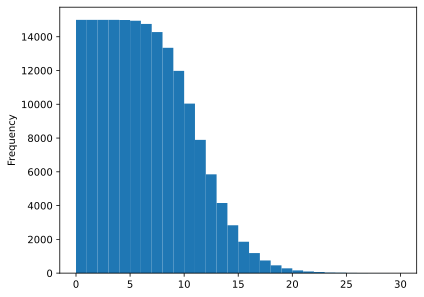

In [23]:
# visualize the distribution of line numbers
train_df['line_number'].plot.hist(bins = 30);

In [24]:
# how much of the line-numbers cover 97.5% of data
seq_len_line_numbers = int(np.percentile(train_df['line_number'],97.5))
seq_len_line_numbers

15

In [25]:
# using tensorflow's one-hot-encoding to create o-h-e tensors of our line-number column
# one-hot-encoding, helps the model to remove discrepancies of the fact considering 'line 4' twice as large as  'line 2', making them categorical rather them some kind of regression.

# anything above seq_len_line_numbers --> encoded to --> all zeros

train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth = seq_len_line_numbers)

val_line_numbers_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth = seq_len_line_numbers)

test_line_numbers_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth = seq_len_line_numbers)

train_line_numbers_one_hot[500:510],train_df['line_number'].to_numpy()[500:510]



(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 array([15, 16,  0,  1,  2,  3,  4,  5,  6,  7]))

**14. Encoding the total lines feature to be used with Model 5**

In [26]:
# how many different total_lines  are there?
train_df['total_lines'].value_counts()

total_lines
11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: count, dtype: int64

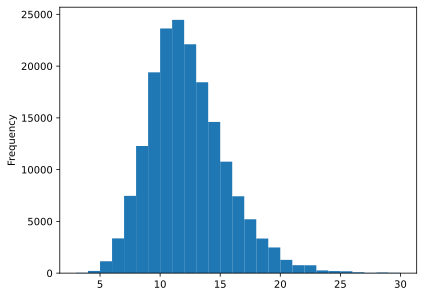

In [27]:
# visualize the distribution of total_lines
train_df['total_lines'].plot.hist(bins=len(np.unique(train_df['total_lines'].to_numpy())));

In [28]:
# how much of the line-numbers cover 98% of data
seq_len_total_lines = int(np.percentile(train_df['total_lines'],98))
seq_len_total_lines

20

In [29]:
# using tensorflow's one-hot-encoding to create o-h-e tensors of our line-number column
# one-hot-encoding, makes the feature as categorical rather than continuous

# anything above seq_len_total_lines --> encoded to --> all zeros

train_total_lines_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), depth = seq_len_total_lines)

val_total_lines_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(), depth = seq_len_total_lines)

test_total_lines_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(), depth = seq_len_total_lines) 

**15. Model 5: Multi-modal input model with Pretrained token embeddings (same as 2) + character embedding (same as 3) + positional embeddings**
* The engineered features must be available at test time
  * line numbers
  * total lines are available at test time.
* Embedding is a common word used for feature/feature space, if we are trying to create any sort of numerical encoding of any type of data.

* STEPS:
  1. Create a token - level embedding (similar to `model 2`)
  2. Create a character level model (similar to `model 3` with a slight modification)
  3. Create a model for line_number feature
  4. Create a model for total_lines feature
  5. Combine (1) and (2) with a concatenate layer (`tf.keras.layers.Concatenate`)
  6. Apply the drop-out and dense layers according to paper to the concatenated output
  7. Combine the outputs of (3), (4), (5) using a concatenate layer (`tf.keras.layers.Concatenate`)
  8. Create an output layer to accept tri-brid embedding and output label probabilities
  9. Combine inputs of (1), (2), (3), (4) and outputs of (7) into a tf.keras.models.Model()


In [36]:
# 1. setup token-level embedding model
token_inputs = tf.keras.layers.Input(shape = [], dtype=tf.string, name = 'token_input')
token_embeddings = UniversalEncodedLayer()(token_inputs)
token_outputs = tf.keras.layers.Dense(128,activation='relu')(token_embeddings)
token_model = tf.keras.models.Model(inputs=token_inputs,outputs=token_outputs)

# 2. setup character-level embedding model
char_inputs = tf.keras.layers.Input(shape = (1,),dtype = tf.string, name = 'char_input')
char_vectorizations = text_char_vectorizer(char_inputs)
char_embeddings = character_embedding(char_vectorizations)
char_bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24))(char_embeddings) # Bi-LSTM used in paper
char_model = tf.keras.models.Model(inputs = char_inputs, outputs = char_bi_lstm)

# 3. create model for line-number feature
line_num_inputs = tf.keras.layers.Input(shape = (seq_len_line_numbers,),dtype=tf.float32,name = 'line_num_input')
### A dense layer on its own is effectively an embedding
line_num_outputs = tf.keras.layers.Dense(units = 32, activation='relu')(line_num_inputs)
line_num_model = tf.keras.models.Model(inputs = line_num_inputs, outputs = line_num_outputs )

# 4. create model for total lines feature
total_lines_inputs = tf.keras.layers.Input(shape = (seq_len_total_lines,),dtype=tf.float32,name = 'total_lines_input')
### A dense layer on its own is effectively an embedding
total_lines_outputs = tf.keras.layers.Dense(units = 32, activation='relu')(total_lines_inputs)
total_lines_model = tf.keras.models.Model(inputs = total_lines_inputs, outputs = total_lines_outputs )

# 5. combine outputs of both models (Concatenate token and char inputs: Create hybrid token embedding)
token_char_concat = tf.keras.layers.Concatenate(name = 'token_char_embedding')([token_model.output,
                                                                             char_model.output])

# 6. apply the drop-out and dense layers according to paper to the concatenated output
token_char_dense = tf.keras.layers.Dense(units = 128, activation='relu')(token_char_concat)

### drop-out applied before output layer
token_char_dropout = tf.keras.layers.Dropout(0.5)(token_char_dense)

# 7. combine the outputs of (3), (4), (5) using a concatenate layer (`tf.keras.layers.Concatenate`)
tri_hybrid_embedding = tf.keras.layers.Concatenate(name = 'token_char_positional_embedding')([line_num_model.output,total_lines_model.output,token_char_dropout])

# 8. create an output layer to accept tri-brid embedding and output label probabilities
output_layer = tf.keras.layers.Dense(units = num_classes, activation='softmax')(tri_hybrid_embedding)

# 9.combine inputs of (1), (2), (3), (4) and outputs of (7) into a tf.keras.models.Model()
model_5 = tf.keras.models.Model(inputs = [token_model.input,char_model.input,line_num_model.input,total_lines_model.input], outputs = output_layer,name="model_5")

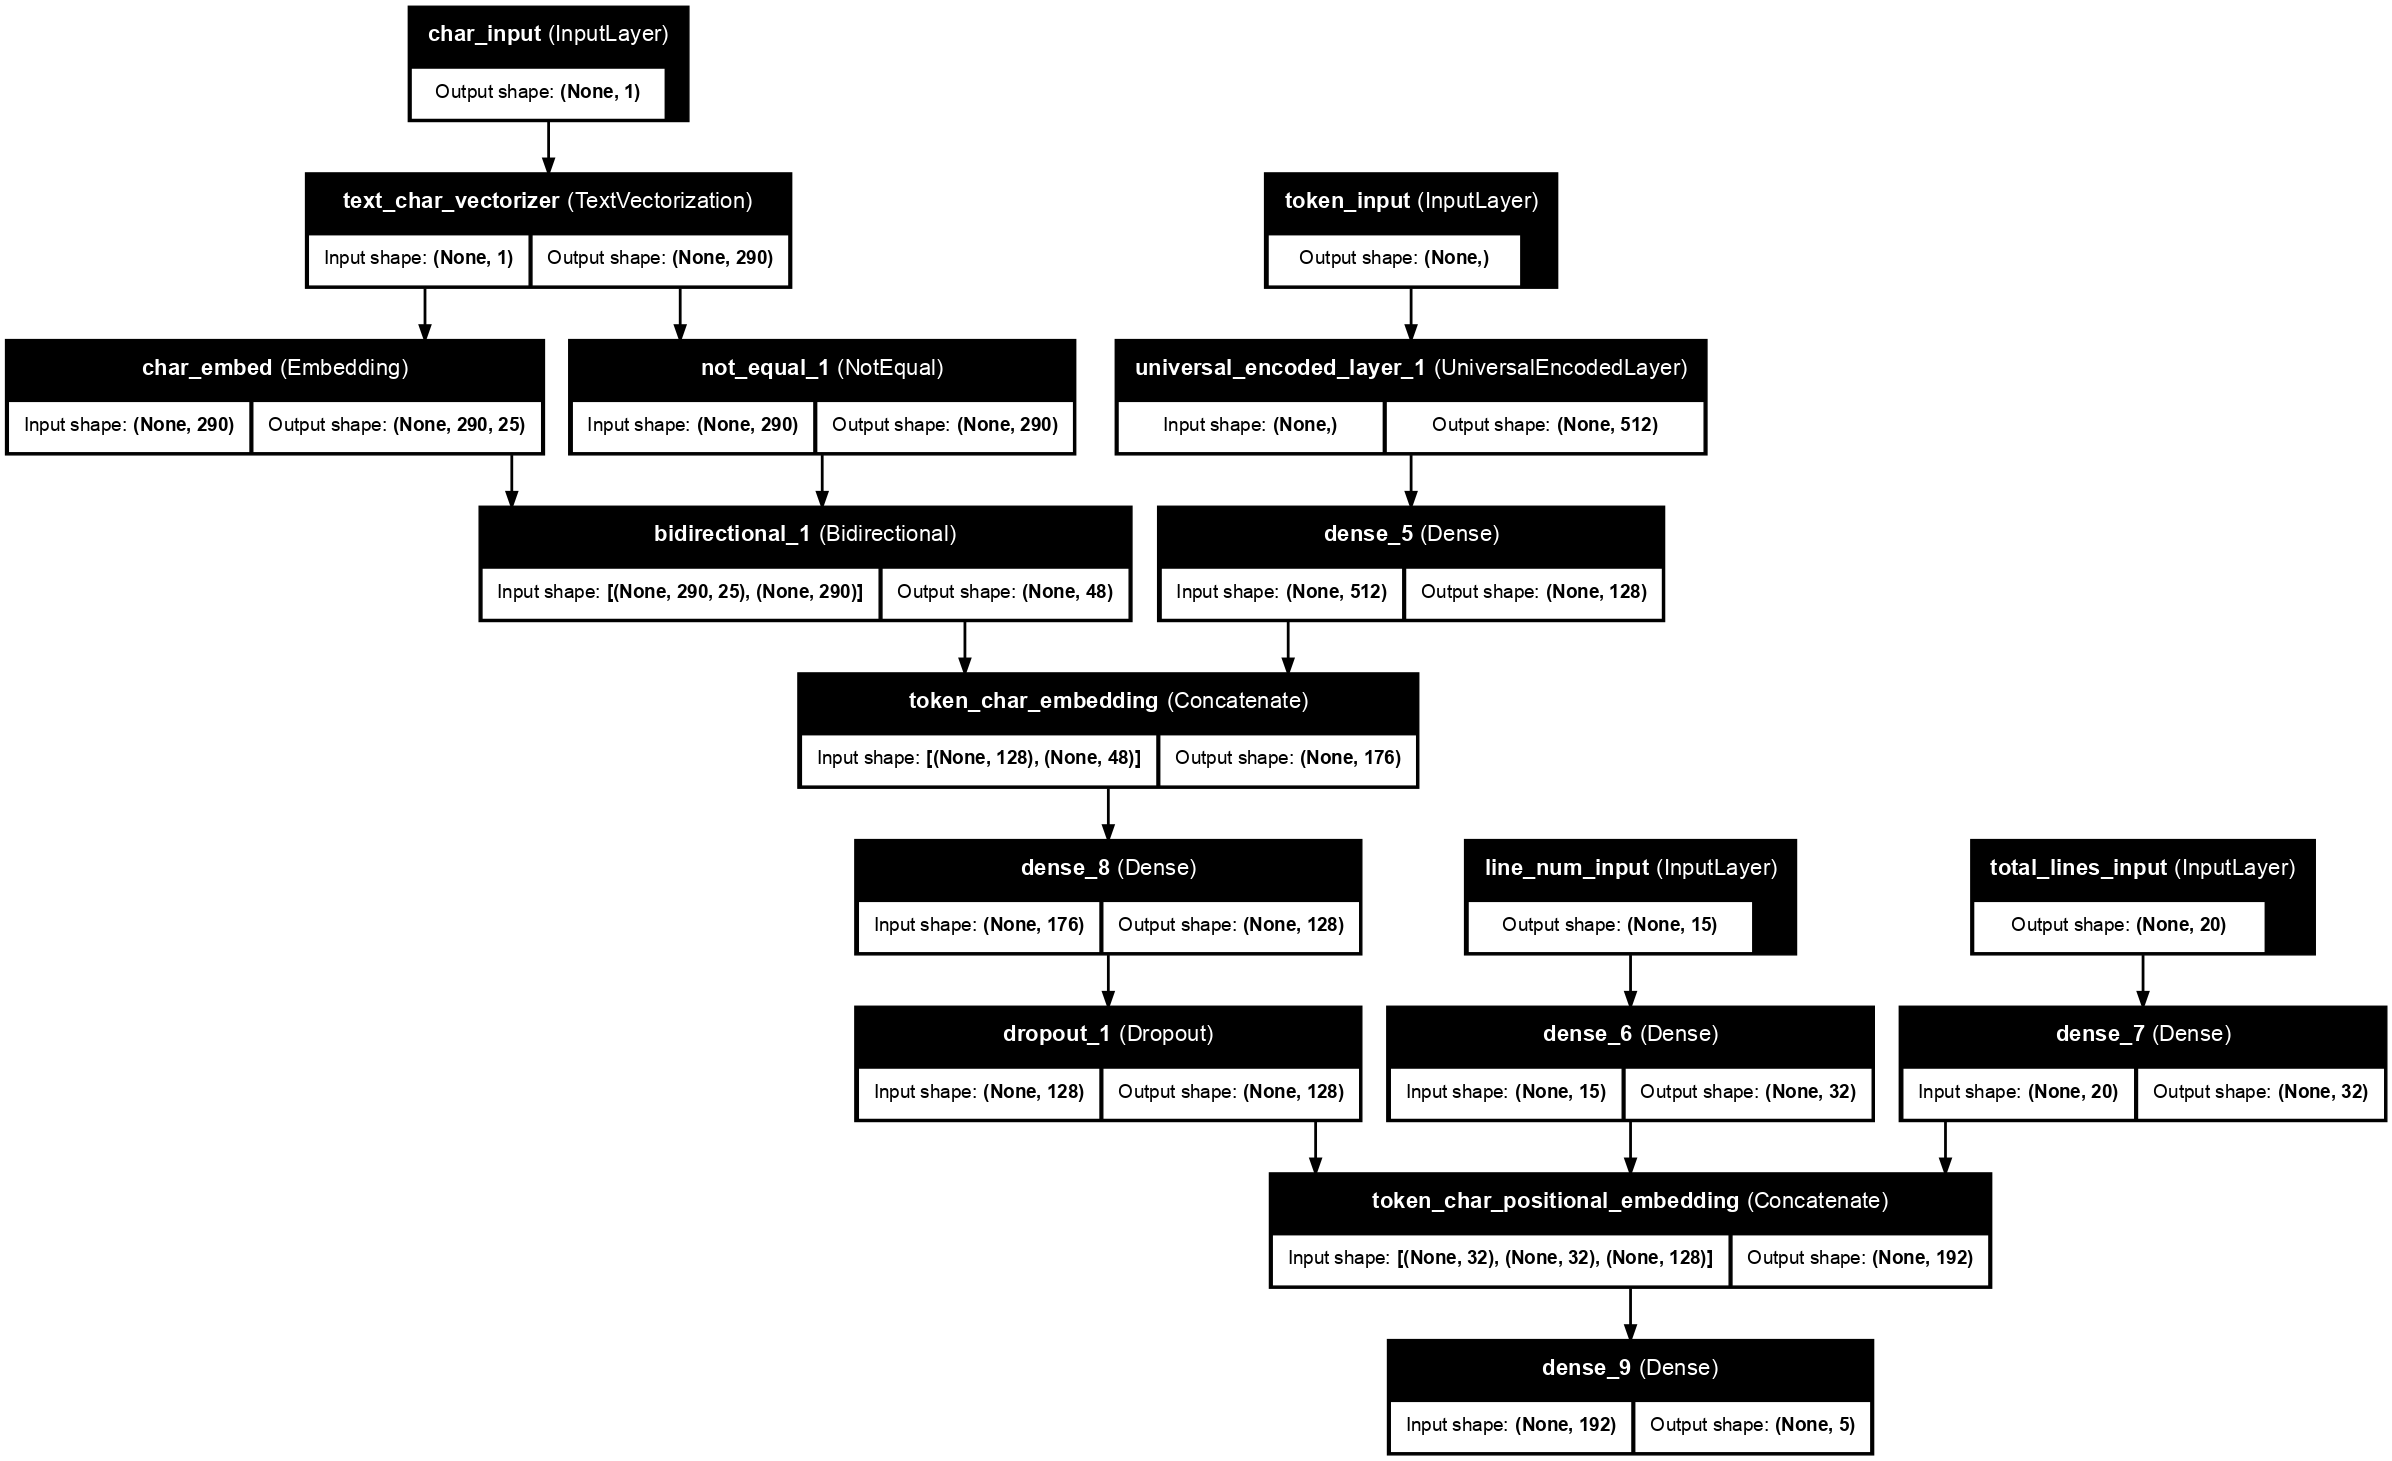

In [37]:
# plotting the model 
from keras.utils import plot_model

plot_model(model_5,
            expand_nested=True,
            dpi=100,show_layer_names=True,show_shapes = True)

**16. Compile Model 5 with label-smoothing**

* Label smoothing is a technique which helps to prevent overfitting

* For example our model gets too confident on a single class (eg: its prediction probability is really high) it may get stuck on that class and not consider other classes....
  * Really confident: `[0.0, 0.0, 1.0, 0.0, 0.0]`
* What label smoothing does is it assigns some of the value from the highest pred-prob to other classes inturn hopefully improving generalization.
  * After label-smoothing (0.2): `[0.1, 0.1, 0.9, 0.1, 0.1]`

<br>
REFERENCE 📖: https://pyimagesearch.com/2019/12/30/label-smoothing-with-keras-tensorflow-and-deep-learning/ 


In [38]:
# compile the model (label-smoothing)
model_5.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2) ,
                 optimizer = tf.keras.optimizers.Adam(), metrics = ['accuracy'])

In [39]:
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_sentences,train_chars,train_line_numbers_one_hot,train_total_lines_one_hot))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_dataset = tf.data.Dataset.zip((train_char_token_pos_data,train_char_token_pos_labels))
# order is important - (token , char) 

val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_sentences,val_chars,val_line_numbers_one_hot,val_total_lines_one_hot))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_dataset = tf.data.Dataset.zip((val_char_token_pos_data,val_char_token_pos_labels))

test_char_token_pos_data = tf.data.Dataset.from_tensor_slices((test_sentences,test_chars,test_line_numbers_one_hot,test_total_lines_one_hot))
test_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_dataset = tf.data.Dataset.zip((test_char_token_pos_data,test_char_token_pos_labels))


BATCH_SIZE = 32
# PREFETCHING AND BATCHING
train_dataset = train_dataset.batch(batch_size=BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size=BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size=BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [40]:
# fitting the model
hist_model_5 = model_5.fit(train_dataset,
            steps_per_epoch = int(0.1*len(train_dataset)),
            epochs = 3,
            validation_data = val_dataset,
            validation_steps = int(0.1*len(val_dataset))
            )

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 55s 90ms/step - accuracy: 0.6145 - loss: 1.2333 - val_accuracy: 0.7889 - val_loss: 0.9976
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 57s 102ms/step - accuracy: 0.8064 - loss: 0.9809 - val_accuracy: 0.8215 - val_loss: 0.9572
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 55s 98ms/step - accuracy: 0.8168 - loss: 0.9623 - val_accuracy: 0.8265 - val_loss: 0.9453


In [41]:
# evaluate model 1
model_5.evaluate(val_dataset)

  1/945 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.7500 - loss: 1.0780

945/945 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - accuracy: 0.8281 - loss: 0.9418


[0.9420732855796814, 0.8279491662979126]

In [42]:
# make predictions using model 1
model_5_pred_probs = model_5.predict(val_dataset)
model_5_pred_probs,model_5_pred_probs.shape

945/945 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step


(array([[0.49374256, 0.10977568, 0.01071061, 0.36808392, 0.01768716],
        [0.5116155 , 0.09840755, 0.04860102, 0.3303371 , 0.01103869],
        [0.25425857, 0.10124075, 0.11615659, 0.46447644, 0.06386767],
        ...,
        [0.03434652, 0.11362545, 0.04995876, 0.0311925 , 0.7708767 ],
        [0.03362248, 0.28826568, 0.08547134, 0.02494938, 0.5676912 ],
        [0.21019113, 0.58730155, 0.09975494, 0.0384646 , 0.0642878 ]],
       dtype=float32),
 (30212, 5))

In [43]:
# convert pred-probs to classes

pred_labels = tf.argmax(model_5_pred_probs,axis=1)
pred_classes  = [class_names[label] for label in pred_labels]
pred_labels,pred_classes

(<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>,
 ['BACKGROUND',
  'BACKGROUND',
  'OBJECTIVE',
  'METHODS',
  'METHODS',
  'RESULTS',
  'RESULTS',
  'RESULTS',
  'RESULTS',
  'CONCLUSIONS',
  'OBJECTIVE',
  'BACKGROUND',
  'OBJECTIVE',
  'OBJECTIVE',
  'METHODS',
  'METHODS',
  'RESULTS',
  'RESULTS',
  'CONCLUSIONS',
  'CONCLUSIONS',
  'CONCLUSIONS',
  'BACKGROUND',
  'BACKGROUND',
  'BACKGROUND',
  'METHODS',
  'CONCLUSIONS',
  'RESULTS',
  'METHODS',
  'METHODS',
  'RESULTS',
  'CONCLUSIONS',
  'CONCLUSIONS',
  'BACKGROUND',
  'OBJECTIVE',
  'BACKGROUND',
  'METHODS',
  'METHODS',
  'RESULTS',
  'RESULTS',
  'RESULTS',
  'CONCLUSIONS',
  'CONCLUSIONS',
  'BACKGROUND',
  'BACKGROUND',
  'BACKGROUND',
  'OBJECTIVE',
  'METHODS',
  'METHODS',
  'RESULTS',
  'RESULTS',
  'METHODS',
  'RESULTS',
  'RESULTS',
  'CONCLUSIONS',
  'RESULTS',
  'CONCLUSIONS',
  'RESULTS',
  'CONCLUSIONS',
  'OBJECTIVE',
  'BACKGROUND',
  'OBJECTIVE',
  'RESULTS',
  'METHODS',


In [44]:
model_5_results = impf.calculate_results(val_labels_encoded,pred_labels)
model_5_results

{'accuracy': 82.79491592744604,
 'precision': 0.8268102125354719,
 'recall': 0.8279491592744604,
 'f1_score': 0.8269941114417286}

**17. Saving and loading our best-performing model**

In [46]:
model_5.save('models/best_model.keras')

In [49]:
loaded_model = tf.keras.models.load_model('models/best_model.keras',custom_objects={'USE':UniversalEncodedLayer})

In [50]:
loaded_model.evaluate(val_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.8281 - loss: 0.9418


[0.9420732855796814, 0.8279491662979126]

In [51]:
loaded_model.evaluate(test_dataset)

942/942 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - accuracy: 0.8259 - loss: 0.9526


[0.9503942728042603, 0.8250871300697327]

**18. Comparing the performance of all the models**

In [57]:
# combine model results into a dataframe

all_results_df = pd.DataFrame({'baseline_results':baseline_results,
                               'model_1_results':model_1_results,
                               'model_2_results':model_2_results,
                               'model_3_results':model_3_results,
                               'model_4_results':model_4_results,
                               'model_5_results':model_5_results
                               }).transpose()
all_results_df

,accuracy,precision,recall,f1_score
baseline_results,72.183238,0.718647,0.721832,0.698925
model_1_results,78.859394,0.785735,0.788594,0.786360
model_2_results,71.431881,0.714442,0.714319,0.711318
model_3_results,67.668476,0.688126,0.676685,0.664999
model_4_results,73.328479,0.734324,0.733285,0.730233
model_5_results,82.794916,0.826810,0.827949,0.826994


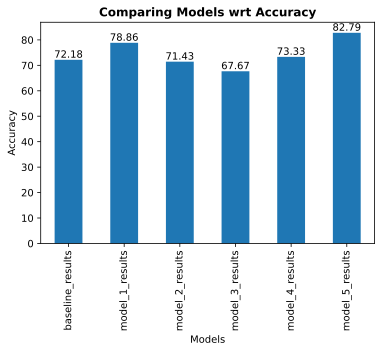

In [58]:
import matplotlib.pyplot as plt

ax = all_results_df['accuracy'].plot(kind='bar', figsize=(6, 4))
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparing Models wrt Accuracy', fontweight='bold')

# Annotating bars with their values
for i, v in enumerate(all_results_df['accuracy']):
    ax.text(i, v + 0.02, f'{v:.2f}', ha='center',va='bottom')

plt.show()

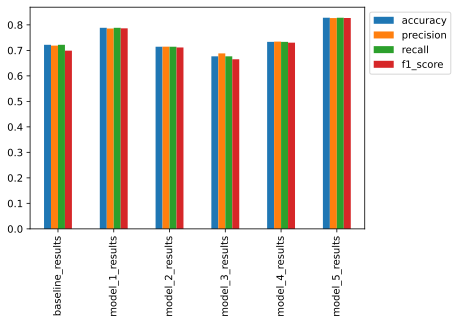

In [59]:
# normalize the accuracy to have all scales same
all_results_df['accuracy']= all_results_df['accuracy']/100.0

# plot and compare all model results
all_results_df.plot(kind='bar',figsize=(6,4)).legend(bbox_to_anchor=(1.0,1.0))

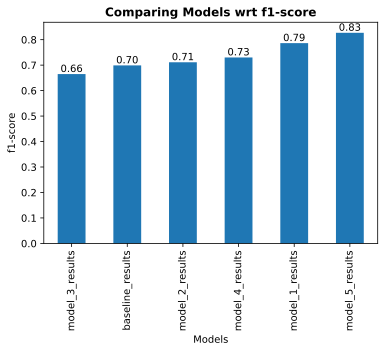

In [62]:
import matplotlib.pyplot as plt

ax = all_results_df.sort_values('f1_score',ascending=True)['f1_score'].plot(kind='bar', figsize=(6, 4))
plt.xlabel('Models')
plt.ylabel('f1-score')
plt.title('Comparing Models wrt f1-score', fontweight='bold')

# Annotating bars with their values
for i, v in enumerate(all_results_df.sort_values('f1_score',ascending=True)['f1_score']):
    ax.text(i, v + 0.0, f'{v:.2f}', ha='center',va='bottom')

plt.show()

***-- CONTD IN NEXT NOTEBOOK --***